# 이 노드의 루브릭                     

1. 아웃포커싱 효과가 적용된 나의 인물모드 사진과 고양이 사진, 배경 전환 크로마키 사진을 각각 1장 이상 성공적으로 제작하였다.             
2. 인물 사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.           
3. 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 솔루션을 구체적으로 제시하였다.            

---           

## 목차

1. 사진 전처리하기           
2. 세그멘테이션으로 사람 분리하기             
3. 세그멘테이션 다뤄보기         
4. 배경만 흐리게 하기  
5. 흐린 배경과 선명한 사람 합성하기    
6. 루브릭 1 달성하기
7. 인물 모드의 문제점 찾기      
8. 인물 모드의 문제점 개선하기               

---

### 1. 사진 전처리하기               

#### 1. 목적 알기! '인물 사진' 이란?                    

- 인물 사진이란, 인물에 초점을 두고 주변의 배경을 흐리게 만드는 포커싱 사진      

- ![인물사진이란](./PostingPic/인물사진이란.png)        

- 이렇게, 인물에 초점을 맞추고 주변 배경을 Blurr 처리하여 인물에게만 집중하도록 만들어준다.           
- 전문 용어로는 __얕은 피사계 심도 or 셸로우 포커스(Shallow Focus)__     

---

- 일반적으로, DSLR과 같은 고가의 장비는 렌즈를 통해 이를 구현해낸다.        
- 하지만, 휴대폰에서는 어떨까? __휴대폰에서는 화각이 다른 두 렌즈를 사용하여__   
- 광각(일반)은 배경, 망원은 인물을 촬영한 뒤 __두 사진을 합성하여 셸로우 포커스를 흉내낸다.__         

---   

- 따라서, 우리는 셸로우 포커스를 흉내내기 위하여

- 1. 배경이 있는 셀카를 준비하고,          
- 2. 신경망을 통해 배경과 사람을 분리하여         
- 3. 각각 처리된 배경 사진과 사람 사진을 합성하여      
- 4. 셸로우 포커스 결과물을 얻는다.

##### 2. 이미지 불러오기           

- 먼저, 샘플로 사용할 사진을 불러오도록 한다.

In [23]:
#필요한 라이브러리 한꺼번에 import 

import cv2
import numpy as np

import os
from glob import glob
from os.path import join

import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

print("모든 라이브러리 임포트 완료!")

모든 라이브러리 임포트 완료!


In [20]:
#샘플로 사용할 이미지를 불러와 처리한다. 

image_path = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex10_ShallowFocus/Images/wendy.png'

sample_image = cv2.imread(image_path)
print('이미지가 잘 불러와졌는지? : ' ,sample_image.shape)

이미지가 잘 불러와졌는지? :  (594, 572, 3)


### 2. 세그멘테이션으로 사람 분리하기                   

##### 1. 세그멘테이션이란?                     

- 이미지 세그멘테이션 : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법              
- 이미지 세그멘테이션은 모든 픽셀에 라벨을 주고, 같은 라벨일 경우 '공통적 특징'을 갖는다고 생각한다.     
- 이 때, 이 '공통적 특징' 은 픽셀 자체의 유사성에 대한 특징일 뿐 물리적 특징과는 관계가 없다.    

__시맨틱 세그멘테이션이란?__  : Classification        
: 우리가 알고 있는 것처럼, 세계를 물리 단위로 인식하는 세그멘테이션.        
- 이미지에서, '사람' '자동차' '나무' '건물' 처럼 각각의 객체를 물리적 단위(덩어리)로 분류한다.     

__인스턴스 세그멘테이션이란?__    
: '사람' 이라는 추상적 정보를 이미지에서 추출해내어, 사진 안의 모든 '사람'에게 같은 라벨을 부여한다.    
- 하나의 사진 안에 여러 명의 사람이 있을 경우, 이를 모두 '사람' 으로 분류하고 각각 개인에게 라벨을 부여한다.    
- 이렇게 동일 카테고리를 우선 분류하고(추상적 추출), 카테고리 안에서 개별 객체를 인식하는 것이 목표이다.   
---
- 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션            
- 워터쉐드 세그멘테이션 : 물체의 경계를 나눌 때, 이미지를 그레이 스케일로 먼저 변환하여 각 위치의 높낮이를 구분한 뒤 낮은 곳부터 물을 채우다가 넘치는 시점에 종료한다.

##### 2. 시맨틱 세그멘테이션 다뤄보기              

- FCN, SegNet, U-Net 등 다양한 모델 중
- DeepLab이라는 세그멘테이션 모델을 사용한다.          

In [21]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # 모델 구조를 직접 구현하지 않고,
    # tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용함 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- 함수에서 모델은 직접 구현하지 않고, tf.Graph()로 불러와 사용          

- preprocessing() : 데이터를 전처리 
1. 모델이 요구하는 크기에 따라 입력 크기를 조정      
2. openCV의 채널(BGR)을 일반적인 RGB 순서로 변경   
3. 이 이미지를 run에 입력값으로 넣어(image)

- run() : 실제 세그멘테이션을 수행

##### 3. 가중치를 가져와 학습 환경 만들기              

- 구글에서 사전 학습시켜놓은 모델의 가중치를 불러들여 실행               
- 구글에서 제공하는 모델을 다운로드받고, DeepLabModel을 초기화함         
- PASCAL VOC 2012라는 데이터셋으로 학습된 v3버전 적용

In [24]:
#다운로드 url 지정해주기
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

#모델을 저장할 위치 알려주기
model_dir = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex10_ShallowFocus/Models'
tf.io.gfile.makedirs(model_dir)

print ('모델의 위치 :', model_dir)

#다운로드한 위치
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')

#만약 이 위치가 존재하지 않을 경우
#재요청
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

#모델은 '다운로드 폴더' 위치에 저장된 그 DeepLabModel입니다요    
MODEL = DeepLabModel(download_path)
print('모델을 무사히 데려왔습니다!')

모델의 위치 : /home/ssac23/SUBMIT_MISSION_GIT/ex10_ShallowFocus/Models
모델을 무사히 데려왔습니다!


##### 4.데려온 모델에, 미리 준비한 샘플 이미지를 입력한다.(sample_image)

In [26]:
resized_img, seg_map = MODEL.run(sample_image)
print (sample_image.shape, resized_img.shape, seg_map.max())

(594, 572, 3) (513, 494, 3) 15


> - 우리가 준비한 샘플 이미지의 크기는 594*572의 컬러(3채널) 이미지         
> - 우리가 리셰이프한 이미지의 크기는 513*494의 컬러(3채널) 이미지    
> - seg_map.max() 는?

In [27]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

> - 구글이 미리 학습시킨 모델에서, 라벨은 총 21개로 나눠진다.     
> - 라벨을 인쇄했을 때, 위의 seg_map.max()는 라벨값 중 가장 큰 값을 의미한다.          
> - 우리는 이 21개의 라벨 중, 'person'인 값만 구해낼 것이다.   

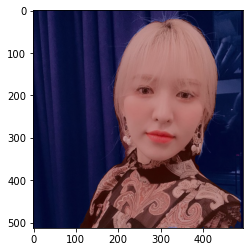

In [29]:
#사람만 추출하는 마스크를 만들어보자! 
img_show = resized_img.copy()

#seg_map이 15인 'person'을 추출할 수 있도록 함.
seg_map = np.where(seg_map == 15, 15, 0)

#정규화
#세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해
img_mask = seg_map * (255/seg_map.max()) 
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#가중치 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

> 사람만 깔끔하게 추출된 것을 볼 수 있다! (일단 내 사진 말고 예쁜 연예인 셀카로 실험하는걸로 ^^...)     

##### 5. 아까 모델에 넣기 위해 사진을 리사이즈 했기 때문에, 이 크기를 다시 복원해준다.

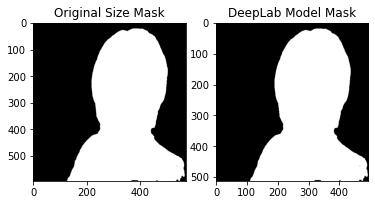

In [30]:
img_mask_up = cv2.resize(img_mask, sample_image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

> - 두 이미지의 크기가 다름을 알 수 있다. (좌표축이 약간 다르다)          
> - cv2.INTER_NEAREST 를 활용해서 원본 사이즈로 보간할 수 있지만,      
> - cv2.INTER_LINEAR를 사용한다.(확실하게 하기 위해)         

> - 보간법 : 이미지의 크기를 변경하는 과정에서, 컴퓨터가 사이사이 픽셀값을 채우도록 하는 방법   
> - 마지막으로 얻은 이미지에, 중간값 128을 기준으로 임계값을 설정하여       
> - 128 이하는 0으로, 128 초과는 255로 만든다.  

### 3. 배경만 흐리게 하기                   

- 이제 선명한 인물을 추출해냈으니, 반대로 배경을 추출하여 블러 처리한다.

##### 1. 배경 추출하기 

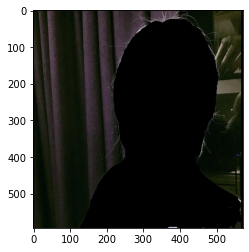

In [32]:
#bitwise를 이용하여 이미지를 반전시킴(사람을 0으로 만듦)
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(sample_image, img_bg_mask)
plt.imshow(img_bg)
plt.show()

> - 사람만 0 처리되어 까맣게 변한 것을 확인할 수 있다

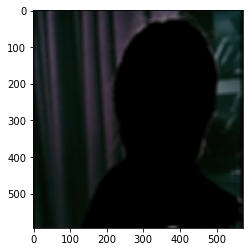

In [34]:
#openCV 라이브러리를 이용해 배경을 블러 처리
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4. 흐린 배경과 선명한 사람 합성하기

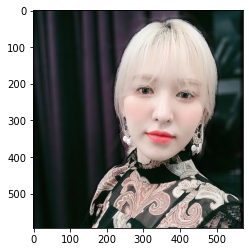

In [35]:
#배경은 블러처리된 것을, 인물은 선명한 사진 그대로를 가져와 합성한다.
img_concat = np.where(img_mask_color==255, sample_image, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 5. 루브릭 1 달성하기                 

- 첫 번째 루브릭에서 명시한 대로, 위에서 거쳐온 일련의 과정을 통해 사진을 정제해본다.       

1. 나의 인물모드 사진 변환하기 
2. 고양이 사진 변환하기        
3. 배경 전환 크로마키 사진

##### 1. 나의 인물모드 사진 변환하기